<a href="https://colab.research.google.com/github/KatBotkowska/WiT_workshops/blob/main/chocolate_bar_ratings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
import pandas as pd
import numpy as np
import io
from unicodedata import normalize
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pip install bioinfokit
import bioinfokit

     |████████████████████████████████| 92kB 3.7MB/s 
  Created wheel for bioinfokit: filename=bioinfokit-2.0.2-cp37-none-any.whl size=56174 sha256=1e3e50b6058fdc86c383ab0ff57a882ec00ac957406b6b3ff98a5731a58c64bc
  Stored in directory: /root/.cache/pip/wheels/8e/3c/1d/369f28890a2139410deef43f69444d49bea2c37d3c3904a0fe
  Created wheel for adjustText: filename=adjustText-0.7.3-cp37-none-any.whl size=7100 sha256=b0975635e5894b9d3efd5c1e2d75ee9ef334c7a482d36059e45c34638ba76f07
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built bioinfokit adjustText


In [3]:
#Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Getting data from Kaggle - not to run (only once at the beggining to download data from Kaggle to gdrive)

In [ ]:
root_path = 'gdrive/My Drive/WiT_workshops/'

In [ ]:
cd 'gdrive/My Drive/WiT_workshops/'

/content/gdrive/My Drive/WiT_workshops


In [ ]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"kbotkowska","key":"90ebb11108c952959800f5549af3472d"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
!kaggle datasets download -d rtatman/chocolate-bar-ratings
# !kaggle datasets download -d sid321axn/beijing-multisite-airquality-data-set

chocolate-bar-ratings.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q chocolate-bar-ratings.zip -d [datasets]

replace [datasets]/flavors_of_cacao.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


#Preprocessing

In [4]:
choco = pd.read_csv('/content/gdrive/MyDrive/WiT_workshops/[datasets]/flavors_of_cacao.csv', encoding='utf-8')

In [5]:
choco.head()

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


In [6]:
choco.columns

Index(['Company \n(Maker-if known)', 'Specific Bean Origin\nor Bar Name',
       'REF', 'Review\nDate', 'Cocoa\nPercent', 'Company\nLocation', 'Rating',
       'Bean\nType', 'Broad Bean\nOrigin'],
      dtype='object')

In [7]:
#remove \n -new line sing from columns name
choco.columns = [column.replace('\n', '') for column in choco.columns.values]
choco.columns

Index(['Company (Maker-if known)', 'Specific Bean Originor Bar Name', 'REF',
       'ReviewDate', 'CocoaPercent', 'CompanyLocation', 'Rating', 'BeanType',
       'Broad BeanOrigin'],
      dtype='object')

In [8]:
#change columns name
choco.columns = ['Company', 'Name', 'ReviewDataReference',
       'ReviewDate', 'CocoaPercent', 'Country', 'Rating', 'BeanType',
       'BroadBeanOrigin']

In [9]:
choco.columns

Index(['Company', 'Name', 'ReviewDataReference', 'ReviewDate', 'CocoaPercent',
       'Country', 'Rating', 'BeanType', 'BroadBeanOrigin'],
      dtype='object')

In [10]:
#remvoe % from CocoaPercent column
choco['CocoaPercent'] = choco['CocoaPercent'].apply(lambda x: float(x.replace('%', ''))/100)

In [11]:
choco['CocoaPercent']

0       0.63
1       0.70
2       0.70
3       0.70
4       0.70
        ... 
1790    0.70
1791    0.65
1792    0.65
1793    0.62
1794    0.65
Name: CocoaPercent, Length: 1795, dtype: float64

In [12]:
 #check isnull
choco.isnull().sum()

Company                0
Name                   0
ReviewDataReference    0
ReviewDate             0
CocoaPercent           0
Country                0
Rating                 0
BeanType               1
BroadBeanOrigin        1
dtype: int64

In [13]:
#remove empty rows 
choco.dropna(inplace=True)

In [14]:
choco.isnull().sum()

Company                0
Name                   0
ReviewDataReference    0
ReviewDate             0
CocoaPercent           0
Country                0
Rating                 0
BeanType               0
BroadBeanOrigin        0
dtype: int64

In [15]:
#there are space sing in column 'BeanType'
choco.loc[1427]['BeanType']

'\xa0'

In [16]:
remove_space = lambda x: x.replace(u'\xa0', u'')
choco['BeanType'] = choco['BeanType'].apply(remove_space)

In [17]:
choco.loc[1427]['BeanType']

''

In [18]:
choco.isnull().sum()

Company                0
Name                   0
ReviewDataReference    0
ReviewDate             0
CocoaPercent           0
Country                0
Rating                 0
BeanType               0
BroadBeanOrigin        0
dtype: int64

In [19]:
choco.isna().sum()

Company                0
Name                   0
ReviewDataReference    0
ReviewDate             0
CocoaPercent           0
Country                0
Rating                 0
BeanType               0
BroadBeanOrigin        0
dtype: int64

In [20]:
choco['BeanType']

0                
1                
2                
3                
4                
          ...    
1790             
1791    Forastero
1792    Forastero
1793             
1794             
Name: BeanType, Length: 1793, dtype: object

##Dataset profie

In [21]:
choco.shape

(1793, 9)

In [22]:
choco.dtypes

Company                 object
Name                    object
ReviewDataReference      int64
ReviewDate               int64
CocoaPercent           float64
Country                 object
Rating                 float64
BeanType                object
BroadBeanOrigin         object
dtype: object

In [23]:
choco.describe()

,ReviewDataReference,ReviewDate,CocoaPercent,Rating
count,1793.000000,1793.000000,1793.000000,1793.000000
mean,1036.126046,2012.326269,0.716991,3.185862
std,553.128742,2.928666,0.063265,0.477668
min,5.000000,2006.000000,0.420000,1.000000
25%,576.000000,2010.000000,0.700000,3.000000
50%,1073.000000,2013.000000,0.700000,3.250000
75%,1502.000000,2015.000000,0.750000,3.500000
max,1952.000000,2017.000000,1.000000,5.000000


In [24]:
choco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1793 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company              1793 non-null   object 
 1   Name                 1793 non-null   object 
 2   ReviewDataReference  1793 non-null   int64  
 3   ReviewDate           1793 non-null   int64  
 4   CocoaPercent         1793 non-null   float64
 5   Country              1793 non-null   object 
 6   Rating               1793 non-null   float64
 7   BeanType             1793 non-null   object 
 8   BroadBeanOrigin      1793 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 220.1+ KB


In [25]:
#sorting data
choco.sort_values(['Rating', 'CocoaPercent'], ascending=False).head(10)

,Company,Name,ReviewDataReference,ReviewDate,CocoaPercent,Country,Rating,BeanType,BroadBeanOrigin
78,Amedei,Chuao,111,2007,0.70,Italy,5.0,Trinitario,Venezuela
86,Amedei,Toscano Black,40,2006,0.70,Italy,5.0,Blend,
1528,Soma,Crazy 88,1077,2013,0.88,Canada,4.0,,"Guat., D.R., Peru, Mad., PNG"
1335,Pralus,Fortissima,93,2006,0.80,France,4.0,"Criollo, Trinitario",Ecuador
1427,Scharffen Berger,San Juan de Cheni,959,2012,0.78,U.S.A.,4.0,,Peru
77,Amedei,Nine,111,2007,0.75,Italy,4.0,Blend,
222,Bonnat,Kaori,1339,2014,0.75,France,4.0,,Brazil
231,Bonnat,Haiti,629,2011,0.75,France,4.0,,Haiti
232,Bonnat,"Madagascar, 100% criollo",629,2011,0.75,France,4.0,Criollo,Madagascar
239,Bonnat,"Porcelana, Venezuela",199,2008,0.75,France,4.0,Criollo (Porcelana),Venezuela


In [26]:
choco[choco['CocoaPercent']>=0.7].head(10)

,Company,Name,ReviewDataReference,ReviewDate,CocoaPercent,Country,Rating,BeanType,BroadBeanOrigin
1,A. Morin,Kpime,1676,2015,0.7,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,0.7,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,0.7,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,0.7,France,3.50,,Peru
5,A. Morin,Carenero,1315,2014,0.7,France,2.75,Criollo,Venezuela
6,A. Morin,Cuba,1315,2014,0.7,France,3.50,,Cuba
7,A. Morin,Sur del Lago,1315,2014,0.7,France,3.50,Criollo,Venezuela
8,A. Morin,Puerto Cabello,1319,2014,0.7,France,3.75,Criollo,Venezuela
9,A. Morin,Pablino,1319,2014,0.7,France,4.00,,Peru
10,A. Morin,Panama,1011,2013,0.7,France,2.75,,Panama


In [27]:
choco[choco['Rating']>=3.5].head(10)

,Company,Name,ReviewDataReference,ReviewDate,CocoaPercent,Country,Rating,BeanType,BroadBeanOrigin
0,A. Morin,Agua Grande,1876,2016,0.63,France,3.75,,Sao Tome
3,A. Morin,Akata,1680,2015,0.70,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,0.70,France,3.50,,Peru
6,A. Morin,Cuba,1315,2014,0.70,France,3.50,,Cuba
7,A. Morin,Sur del Lago,1315,2014,0.70,France,3.50,Criollo,Venezuela
8,A. Morin,Puerto Cabello,1319,2014,0.70,France,3.75,Criollo,Venezuela
9,A. Morin,Pablino,1319,2014,0.70,France,4.00,,Peru
13,A. Morin,Equateur,1011,2013,0.70,France,3.75,,Ecuador
17,A. Morin,Chuao,1015,2013,0.70,France,4.00,Trinitario,Venezuela
19,A. Morin,Chanchamayo Province,1019,2013,0.70,France,3.50,,Peru


In [28]:
chocoMelt = choco.melt(id_vars=['Country','Company', 'Name'])  #zmiana kolumn na wiersze - tworzy nową zmienną variable zawierającą nazwy kolumn, id_vars - wartości które są bez zmian, value - wartości dla zmiennej variable
chocoMelt.sort_values(['Country'], ascending=False).head(10)

,Country,Company,Name,variable,value
9121,Wales,Baravelli's,single estate,BroadBeanOrigin,Costa Rica
5535,Wales,Baravelli's,single estate,Rating,2.75
3742,Wales,Baravelli's,single estate,CocoaPercent,0.8
156,Wales,Baravelli's,single estate,ReviewDataReference,955
1949,Wales,Baravelli's,single estate,ReviewDate,2012
7328,Wales,Baravelli's,single estate,BeanType,
1054,Vietnam,Marou,Dong Nai,ReviewDataReference,845
1051,Vietnam,Marou,"Dak Lak, Batch 2451",ReviewDataReference,1650
1052,Vietnam,Marou,"Tan Phu Dong, Treasure Island",ReviewDataReference,1149
1053,Vietnam,Marou,Ba Ria,ReviewDataReference,845


In [29]:
countries = choco.groupby('Country').agg({
    'Rating': 'mean',
    'Name': 'count'
})
countries.sort_values(by='Rating', ascending=False).head(10)

,Rating,Name
Country,,
Chile,3.750000,2
Amsterdam,3.500000,4
Netherlands,3.500000,4
Philippines,3.500000,1
Iceland,3.416667,3
Vietnam,3.409091,11
Brazil,3.397059,17
Poland,3.375000,8
Australia,3.357143,49


In [30]:
countries_with_cocoapercent = choco.groupby('Country').agg({
    'Rating': 'mean',
    'CocoaPercent': 'mean'
})
countries_with_cocoapercent.sort_values(by='Rating', ascending=False).head(10)

,Rating,CocoaPercent
Country,,
Chile,3.750000,0.700000
Amsterdam,3.500000,0.732500
Netherlands,3.500000,0.700000
Philippines,3.500000,0.650000
Iceland,3.416667,0.686667
Vietnam,3.409091,0.745455
Brazil,3.397059,0.698235
Poland,3.375000,0.718750
Australia,3.357143,0.702245


In [31]:
countries_with_cocoapercent.sort_values(by='CocoaPercent', ascending=False).head(10)

,Rating,CocoaPercent
Country,,
Sao Tome,2.937500,0.821250
Wales,2.750000,0.800000
Ghana,2.750000,0.800000
Ireland,2.812500,0.785000
Portugal,2.750000,0.760000
Eucador,3.000000,0.750000
Niacragua,2.750000,0.750000
Honduras,3.208333,0.750000
Fiji,3.250000,0.750000


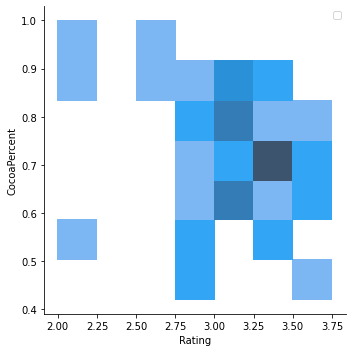

In [32]:
df = choco[['Rating','CocoaPercent']].groupby(["CocoaPercent"]).median().reset_index()
sns.displot(x='Rating', y='CocoaPercent', data=df, legend=['Average Rating', 'Average CocoaPercent'])
plt.legend(labels=['Average Rating', 'Average CocoaPercent'])
plt.xlabel = 'Average Rating'

In [33]:
choco[['CocoaPercent', 'Rating']].corr()

#The correlation is negative - but weak (only -0.16). 
#In the case of 'CocoaPercent' column the data is continuous, so it has to be checked by ANOVA (in the case of normal distribution and variance homogeneity) or with a non-parametric test.

,CocoaPercent,Rating
CocoaPercent,1.000000,-0.164758
Rating,-0.164758,1.000000


In [34]:
p_value=pearsonr(choco['Rating'], choco['CocoaPercent'])[1]
p_value.round(10)
#P_value is 0.0 - Reject null hypotese so there is a correlation between those columns.

0.0

In [35]:
choco['Rating'].unique()


array([3.75, 2.75, 3.  , 3.5 , 4.  , 3.25, 2.5 , 5.  , 1.75, 1.5 , 2.25,
       2.  , 1.  ])

In [36]:
choco['CocoaPercent'].unique()
#data is continous

array([0.63 , 0.7  , 0.6  , 0.8  , 0.88 , 0.72 , 0.55 , 0.75 , 0.65 ,
       0.85 , 0.73 , 0.64 , 0.66 , 0.68 , 0.5  , 1.   , 0.77 , 0.9  ,
       0.71 , 0.83 , 0.78 , 0.74 , 0.76 , 0.86 , 0.82 , 0.69 , 0.91 ,
       0.42 , 0.61 , 0.735, 0.62 , 0.67 , 0.58 , 0.605, 0.79 , 0.81 ,
       0.57 , 0.725, 0.56 , 0.46 , 0.89 , 0.99 , 0.84 , 0.53 , 0.87 ])

#check ANOVA test - normal distribution and homogeneity of samples
Anova test can be used under 2 conditions: homogeneity of variances and normal distribution


In [37]:
choco_anova = choco[['Rating', 'CocoaPercent']].groupby('Rating')
choco_anova=choco_anova.apply(lambda x:x)
choco_anova=choco_anova.set_index('Rating')


# choco_anova.reset_index(level=['Rating',"CocoaPercent"]).head()

In [38]:
choco_anova = choco_anova.T
choco_anova

Rating,3.75,2.75,3.00,3.50,3.50,2.75,3.50,3.50,3.75,4.00,2.75,3.00,3.25,3.75,2.75,3.00,3.25,4.00,3.25,3.50,4.00,3.50,3.75,3.75,3.75,2.75,3.25,3.50,3.50,2.75,3.00,3.00,3.75,2.75,2.75,2.75,2.75,3.00,2.50,2.50,...,3.25,4.00,3.50,3.00,2.75,2.50,3.00,3.25,3.25,3.25,3.50,3.00,3.50,2.75,2.75,3.00,3.50,3.50,3.75,3.25,3.50,3.50,3.75,2.75,3.50,3.50,3.00,3.50,3.75,3.00,3.00,3.25,3.75,3.25,3.50,3.75,3.00,3.50,3.25,3.00
CocoaPercent,0.63,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.63,0.7,0.63,0.7,0.7,0.6,0.8,0.88,0.72,0.55,0.7,0.7,0.75,0.75,0.75,0.65,0.75,0.75,0.75,0.75,...,0.7,0.7,0.7,0.66,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.6,0.7,0.7,0.85,0.85,0.7,0.78,0.78,0.65,0.68,0.66,0.72,0.8,0.72,0.65,0.7,0.7,0.62,0.75,0.75,0.9,0.7,0.68,0.58,0.7,0.65,0.65,0.62,0.65


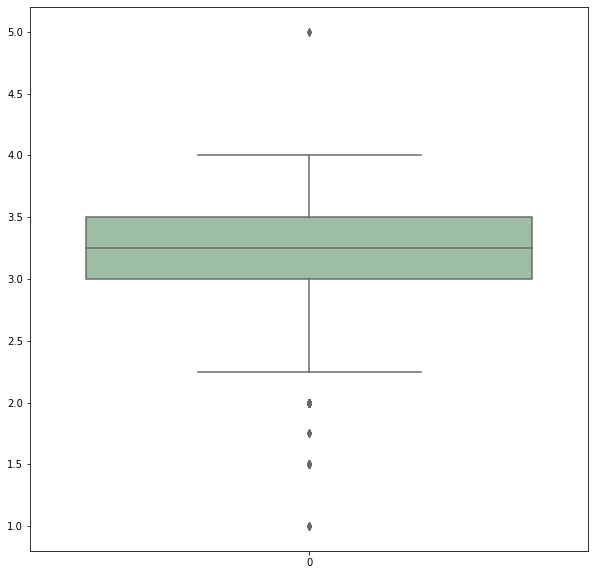

In [39]:
plt.figure(figsize=(10,10))
ax = sns.boxplot( data=choco['Rating'], color='#99c2a2')
#ax = sns.swarmplot(x="CocoaPercent", y="Rating", data=choco_anova, color='#7d0013')
plt.show()

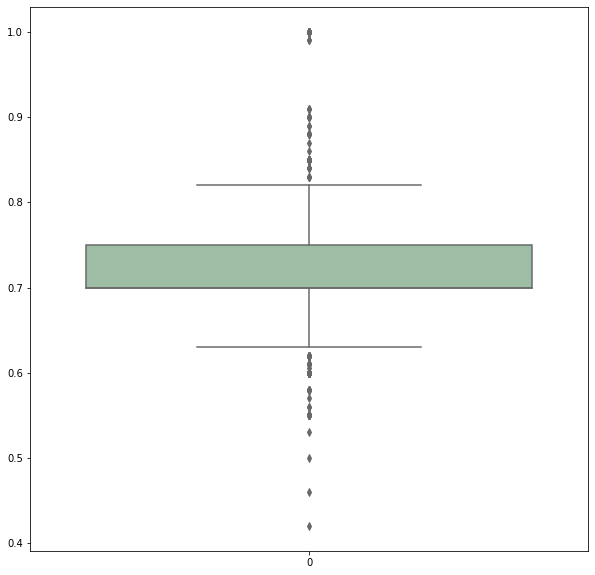

In [40]:
plt.figure(figsize=(10,10))
ax = sns.boxplot( data=choco['CocoaPercent'], color='#99c2a2')
#ax = sns.swarmplot(x="CocoaPercent", y="Rating", data=choco_anova, color='#7d0013')
plt.show()

###P value

In [41]:
fvalue, pvalue = stats.f_oneway(choco['CocoaPercent'], choco['Rating'])
#print(fvalue, pvalue)
print(pvalue.round(10))

0.0


In [42]:
# I called the dictionary:last_try. I tried to prepare the data many times, it was the last attempt :)
last_try={}
keys = [key for key in set(choco['Rating'])]

for elem in choco['Rating']:
    if elem in last_try.keys():
        last_try[elem].append(choco[choco.Rating==elem].CocoaPercent)
    else:
        last_try[elem] = choco[choco.Rating==elem].CocoaPercent

In [43]:
type(last_try)

dict

In [44]:
pd.DataFrame(last_try).describe()

,3.75,2.75,3.00,3.50,4.00,3.25,2.50,5.00,1.75,1.50,2.25,2.00,1.00
count,210.000000,259.000000,341.000000,392.000000,97.000000,303.000000,126.000000,2.0,3.000000,10.000000,14.000000,32.000000,4.000000
mean,0.708500,0.721795,0.717742,0.711607,0.708144,0.714125,0.717897,0.7,0.906667,0.848000,0.740000,0.766250,0.782500
std,0.038173,0.072325,0.064323,0.050010,0.039007,0.058884,0.070564,0.0,0.161658,0.153101,0.099383,0.118805,0.145688
min,0.500000,0.420000,0.550000,0.550000,0.600000,0.550000,0.550000,0.7,0.720000,0.650000,0.550000,0.530000,0.700000
25%,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.7,0.860000,0.700000,0.705000,0.700000,0.700000
50%,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.710000,0.7,1.000000,0.880000,0.725000,0.750000,0.715000
75%,0.720000,0.750000,0.750000,0.730000,0.730000,0.750000,0.750000,0.7,1.000000,1.000000,0.757500,0.812500,0.797500
max,0.900000,1.000000,1.000000,1.000000,0.880000,0.990000,1.000000,0.7,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
last_try.keys()

dict_keys([3.75, 2.75, 3.0, 3.5, 4.0, 3.25, 2.5, 5.0, 1.75, 1.5, 2.25, 2.0, 1.0])

###Bartlett test

In [46]:
#bartlett test  
p = stats.bartlett(last_try[1.0], last_try[1.5], last_try[1.75], last_try[3.75], last_try[2.75], last_try[3.0], last_try[3.5], last_try[4.0], last_try[3.25], last_try[2.5], last_try[5.0], last_try[2.25], last_try[2.0] )
p

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2241: RuntimeWarning: divide by zero encountered in log
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)


BartlettResult(statistic=inf, pvalue=0.0)

Bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances. Null hypotesis is rejected because of p value.

###Levene test

In [47]:
#Levene test  
p = stats.levene(last_try[1.0], last_try[1.5], last_try[1.75], last_try[3.75], last_try[2.75], last_try[3.0], last_try[3.5], last_try[4.0], last_try[3.25], last_try[2.5], last_try[5.0], last_try[2.25], last_try[2.0] )
p

LeveneResult(statistic=11.584121196479193, pvalue=8.749007675742454e-23)

In [48]:
round(float(8.749007675742454e-23))

0

The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality. Null hypotesis is rejected because of p value.

###Anderson - check normal distribution

In [49]:
data_anderson=(last_try[1.0], last_try[1.5], last_try[1.75], last_try[3.75], last_try[2.75], last_try[3.0], last_try[3.5], last_try[4.0], last_try[3.25], last_try[2.5], last_try[5.0], last_try[2.25], last_try[2.0] )

In [50]:
for elem in data_anderson:
    result = stats.anderson(elem)
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 0.671
15.000: 1.317, data looks normal (fail to reject H0)
10.000: 1.499, data looks normal (fail to reject H0)
5.000: 1.799, data looks normal (fail to reject H0)
2.500: 2.098, data looks normal (fail to reject H0)
1.000: 2.496, data looks normal (fail to reject H0)
Statistic: 0.801
15.000: 0.501, data does not look normal (reject H0)
10.000: 0.570, data does not look normal (reject H0)
5.000: 0.684, data does not look normal (reject H0)
2.500: 0.798, data does not look normal (reject H0)
1.000: 0.950, data looks normal (fail to reject H0)
Statistic: 0.488
15.000: -1.296, data does not look normal (reject H0)
10.000: -1.476, data does not look normal (reject H0)
5.000: -1.771, data does not look normal (reject H0)
2.500: -2.065, data does not look normal (reject H0)
1.000: -2.457, data does not look normal (reject H0)
Statistic: 11.341
15.000: 0.566, data does not look normal (reject H0)
10.000: 0.644, data does not look normal (reject H0)
5.000: 0.773, data does not look n

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1780: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s


The null hypotesis that the data comes from normal distribution is rejected.

Thus, the null hypothesis of equal variances and normal distribution are rejected and it is concluded that there is a difference between the variances in the population - the samples are not homogeneous and the distribution is not normal.


##Spearman test

In [51]:
data1=choco['Rating']
data2=choco['CocoaPercent']
coef, p = stats.spearmanr(data1, data2)
print('Spearmans correlation coefficient: %.3f' % coef)
print('Spearmans pvalue: %.5f' % p)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: -0.123
Spearmans pvalue: 0.00000
Samples are correlated (reject H0) p=0.000


##Kendall Correlation Coefficient

In [52]:
coef, p = stats.kendalltau(data1, data2)
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

Kendall correlation coefficient: -0.094
Samples are correlated (reject H0) p=0.000


##Kruskal Wallis

In [53]:
#Kruskal Wallis test  
p = stats.kruskal(last_try[1.0], last_try[1.5], last_try[1.75], last_try[3.75], last_try[2.75], last_try[3.0], last_try[3.5], last_try[4.0], last_try[3.25], last_try[2.5], last_try[5.0], last_try[2.25], last_try[2.0] )
p

KruskalResult(statistic=39.65123708491793, pvalue=8.214790262355974e-05)

In [54]:
round(float(8.214790262355974e-05))

0

##Regression model - to do (?)

In [165]:
y = choco_anova['CocoaPercent']
X=choco_anova['Rating']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           CocoaPercent   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                          5.131e+04
Date:                Sun, 04 Apr 2021   Prob (F-statistic):                        0.00
Time:                        16:40:35   Log-Likelihood:                          1083.5
No. Observations:                1793   AIC:                                     -2165.
Df Residuals:                    1792   BIC:                                     -2159.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

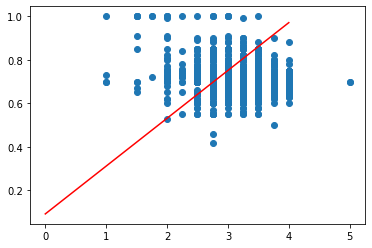

In [166]:
# plotting the original values
x = choco_anova['Rating'].tolist()
y = choco_anova['CocoaPercent'].tolist()
plt.scatter(x, y)
  
# finding the maximum and minimum
# values of x, to get the
# range of data
max_x = choco_anova['Rating'].max()
min_x = choco_anova['CocoaPercent'].min()
  
# range of values for plotting
# the regression line
x = np.arange(min_x, max_x, 1)
  
# the substituted equation
y = 0.2196* x
  
# plotting the regression line
plt.plot(y, 'r')
plt.show()

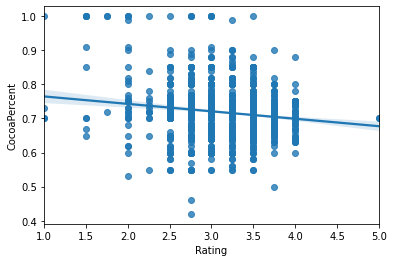

In [159]:
ax = sns.regplot(x="Rating", y="CocoaPercent", data=choco_anova)
